In [42]:
import pandas as pd
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [28]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [29]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [30]:
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [31]:
# Список уникальных регионов
unique_regions = data['region'].unique()
unique_regions

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Данные успешно загружены, пропущенных значений нет.

Уникальные регионы: ['southwest' 'southeast' 'northwest' 'northeast']

# **Однофакторный ANOVA (способ 1 - Scipy)**

In [32]:
# Разделение данных по регионам
groups = [data[data['region'] == region]['bmi'] for region in unique_regions]

# Выполнение ANOVA теста
stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(39.49505720170283), pvalue=np.float64(1.881838913929143e-24))

# **Однофакторный ANOVA (способ 2 - statsmodels)**

In [36]:
model = ols('bmi ~ C(region)', data=data).fit()
anova_results = sm.stats.anova_lm(model, typ = 2)
anova_results

,sum_sq,df,F,PR(>F)
C(region),4055.880631,3.0,39.495057,1.881839e-24
Residual,45664.319755,1334.0,NaN,NaN


In [37]:
# Создание модели
model = ols('bmi ~ C(region)', data=data).fit()
anova_results = anova_lm(model)

print("\nОднофакторный ANOVA (statsmodels):")
print(anova_results)


Однофакторный ANOVA (statsmodels):
               df        sum_sq      mean_sq          F        PR(>F)
C(region)     3.0   4055.880631  1351.960210  39.495057  1.881839e-24
Residual   1334.0  45664.319755    34.231124        NaN           NaN


# **Попарные t-тесты с поправкой Бонферрони**

In [40]:
# Попарные сравнения
comparisons = []
p_values = []

for i in range(len(unique_regions)):
    for j in range(i+1, len(unique_regions)):
        t_stat, p_val = stats.ttest_ind(
            data[data['region'] == unique_regions[i]]['bmi'],
            data[data['region'] == unique_regions[j]]['bmi']
        )
        comparisons.append(f"{unique_regions[i]} vs {unique_regions[j]}")
        p_values.append(p_val)
comparisons, p_values

(['southwest vs southeast',
  'southwest vs northwest',
  'southwest vs northeast',
  'southeast vs northwest',
  'southeast vs northeast',
  'northwest vs northeast'],
 [np.float64(5.4374009639680636e-09),
  np.float64(0.001076958496307695),
  np.float64(0.0019086161671573072),
  np.float64(2.643571405230106e-19),
  np.float64(1.186014937424813e-17),
  np.float64(0.951929170821864)])

In [41]:
# Поправка Бонферрони
bonferroni_p = [p * len(comparisons) for p in p_values]

# Создание DataFrame для результатов
pairwise_results = pd.DataFrame({
    'Comparison': comparisons,
    'p-value': p_values,
    'Bonferroni p-value': bonferroni_p
})

print("\nПопарные сравнения с поправкой Бонферрони:")
print(pairwise_results)


Попарные сравнения с поправкой Бонферрони:
               Comparison       p-value  Bonferroni p-value
0  southwest vs southeast  5.437401e-09        3.262441e-08
1  southwest vs northwest  1.076958e-03        6.461751e-03
2  southwest vs northeast  1.908616e-03        1.145170e-02
3  southeast vs northwest  2.643571e-19        1.586143e-18
4  southeast vs northeast  1.186015e-17        7.116090e-17
5  northwest vs northeast  9.519292e-01        5.711575e+00


---Наиболее значимые различия:

Между southeast и northwest (p = 1.59e-18)

Между southeast и northeast (p = 7.12e-17)
  
Между southwest и southeast (p = 3.26e-08)

---Умеренно значимые различия:

Между southwest и northwest (p = 0.0065)

Между southwest и northeast (p = 0.0115)

---Незначимые различия:

Между northwest и northeast (p = 5.71) - нет статистически значимой разницы

# **Пост-хок тест Тьюки и график**

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.0263,0.9999,-1.1552,1.2078,False
northeast,southeast,4.1825,0.0,3.033,5.332,True
northeast,southwest,1.4231,0.0107,0.2416,2.6046,True
northwest,southeast,4.1562,0.0,3.0077,5.3047,True
northwest,southwest,1.3968,0.0127,0.2162,2.5774,True
southeast,southwest,-2.7594,0.0,-3.9079,-1.6108,True


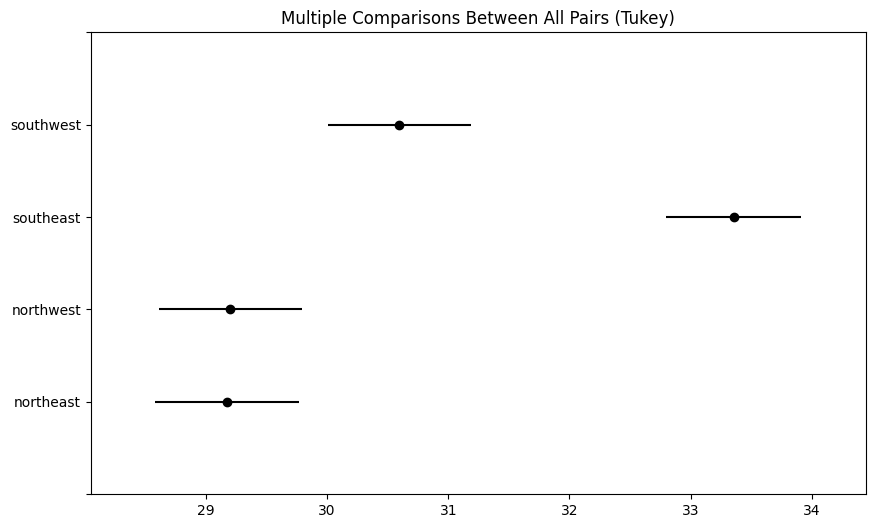

In [52]:
tukey = pairwise_tukeyhsd(endog=data['bmi'],
                          groups=data['region'],
                          alpha=0.05)
tukey.plot_simultaneous()  # График попарных сравнений
plt.vlines(x=49.57, ymin = -0.5, ymax = 4.5, color='red')
tukey.summary()

# **Двухфакторный ANOVA (регион и пол)**

In [49]:
model_2 = ols('bmi ~ C(region) + C(sex) + C(region):C(sex)', data=data).fit()
sm.stats.anova_lm(model_2, typ=2)


,sum_sq,df,F,PR(>F)
C(region),4034.975135,3.0,39.398134,2.163195e-24
C(sex),86.007035,1.0,2.519359,1.126940e-01
C(region):C(sex),174.157808,3.0,1.700504,1.650655e-01
Residual,45404.154911,1330.0,NaN,NaN


# **Пост-хок тесты Тьюки для двухфакторного ANOVA**

group1,group2,meandiff,p-adj,lower,upper,reject
northeast / female,northeast / male,-0.2998,0.9998,-2.2706,1.6711,False
northeast / female,northwest / female,-0.0464,1.0,-2.0142,1.9215,False
northeast / female,northwest / male,-0.2042,1.0,-2.1811,1.7728,False
northeast / female,southeast / female,3.3469,0.0,1.41,5.2839,True
northeast / female,southeast / male,4.6657,0.0,2.7634,6.568,True
northeast / female,southwest / female,0.7362,0.9497,-1.2377,2.71,False
northeast / female,southwest / male,1.8051,0.1007,-0.1657,3.776,False
northeast / male,northwest / female,0.2534,0.9999,-1.7083,2.2152,False
northeast / male,northwest / male,0.0956,1.0,-1.8752,2.0665,False
northeast / male,southeast / female,3.6467,0.0,1.7159,5.5775,True


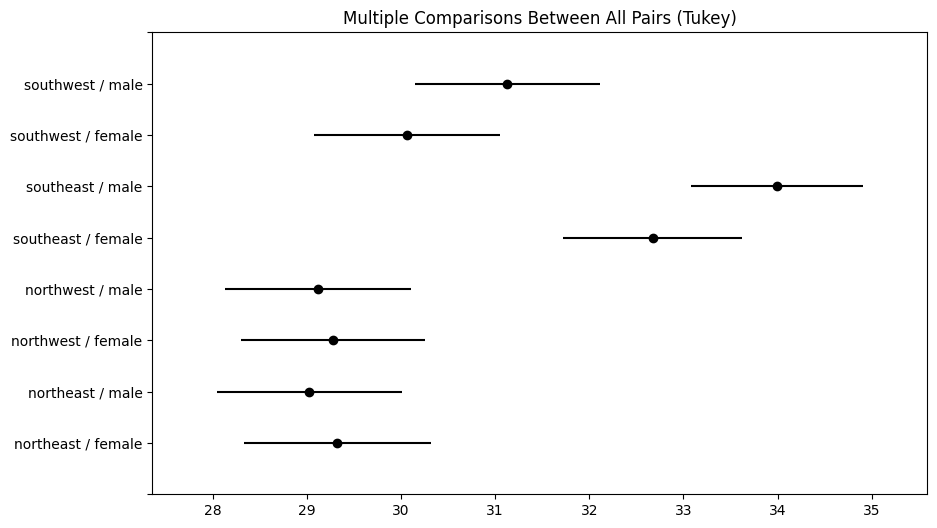

In [50]:
data['region_sex'] = data['region'] + " / " + data['sex']

tukey = pairwise_tukeyhsd(endog=data['bmi'],
                         groups=data['region_sex'],
                         alpha=0.05)
tukey.plot_simultaneous()
tukey.summary()

# **выводы**

Регион сильно влияет на BMI

*   В юго-восточном регионе (southeast) люди имеют самый высокий BMI - в среднем на 4 единицы больше, чем в других регионах
*   Северо-запад (northwest) и северо-восток (northeast) почти не отличаются по BMI

*   Юго-запад (southwest) - где-то посередине
Пол не так важен, как регион

*   В целом мужчины и женщины не сильно различаются по BMI
*   Но если смотреть по регионам:

     .   В северных регионах мужчины имеют чуть более высокий BMI, чем женщины


     
        . В других регионах разницы почти нет
Самые "проблемные" группы:

*   Мужчины в юго-восточном регионе - самый высокий BMI
*   Женщины в северо-западном регионе - самый низкий BMI

Вывод: Где живешь - важнее, чем кто ты (мужчина или женщина), когда речь идет о весе. Юго-восток США - регион, где проблема лишнего веса стоит особенно остро.











